In [1]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import os
import re
import numpy as np
from scipy import stats
import pprint
pp = pprint.PrettyPrinter(indent=4)
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


# Code to process imdb list data

In [2]:
p_year = re.compile('\([12][890]\d{2}\)')
p_episode = re.compile('\{.*\}')

def rating_process(line, min_votes=100, verbose=0):
    
    entries = [elem for elem in line.split(' ') if len(elem) > 0]
    
    out = {}
    out['distribution'] = entries[0]
    out['votes'] = entries[1]    
    out['rating'] = entries[2]
    
    if int(out['votes']) < min_votes:
        return None
    
    title_year_episode = ' '.join(entries[3:])

    
    try:
        year = p_year.findall(title_year_episode)[0][1:-1]
        title = p_year.split(title_year_episode)[0].strip()
        episode = ''
        episode_string = p_year.split(title_year_episode)[1]
        episode_findall = p_episode.findall(episode_string)
        if len(episode_findall) == 1:
            episode = episode_findall[0][1:-1]
            episode = episode_findall[0]
        int(year)
    except:
        if verbose > 0:
            print 'WARNING this file did not process',title_year_episode.strip()
        return None
    
    if title[0] == '"' and title[-1] == '"':
        title = title[1:-1]
    out['year'] = year
    out['title'] = title
    out['episode'] = episode

    return out

examples = [
#     Real examples
    '1....521.1      10   6.3  ".hack//Tasogare no udewa densetsu" (2003) {Densetsu no yusha (#1.1)}\n',
    '      0000001212   16660   7.6  "12 Monkeys" (2015)\n',
    '      ....1.34.1       9   7.6  "1st Look" (2011) {Columbiana (#1.9)}\n',
#     This one has a different year format
    '1000011003      58   6.5  "Amas de casa desesperadas" (2006/II)\n',
    '.....161..       6   7.0  "Amateurs" (2014) {(#1.1)}\n'
#     This one stops using "" for the title 
    '030.0..1.3      21   5.8  Struggle (2002)\n',
#     Includes a (V) and uses '' in the title
    "....112.02      11   7.5  The Making of 'The Mummy: Tomb of the Dragon Emperor' (2008) (V)\n",
#   Year not given here  
    '2........7       9   8.0  "By Any Means" (????)\n'
    
]

for example in examples: 
    print example[:-1]
    pp.pprint(rating_process(example, min_votes=1, verbose =3)) 
    print
    



1....521.1      10   6.3  ".hack//Tasogare no udewa densetsu" (2003) {Densetsu no yusha (#1.1)}
{   'distribution': '1....521.1',
    'episode': '{Densetsu no yusha (#1.1)}',
    'rating': '6.3',
    'title': '.hack//Tasogare no udewa densetsu',
    'votes': '10',
    'year': '2003'}

      0000001212   16660   7.6  "12 Monkeys" (2015)
{   'distribution': '0000001212',
    'episode': '',
    'rating': '7.6',
    'title': '12 Monkeys',
    'votes': '16660',
    'year': '2015'}

      ....1.34.1       9   7.6  "1st Look" (2011) {Columbiana (#1.9)}
{   'distribution': '....1.34.1',
    'episode': '{Columbiana (#1.9)}',
    'rating': '7.6',
    'title': '1st Look',
    'votes': '9',
    'year': '2011'}

1000011003      58   6.5  "Amas de casa desesperadas" (2006/II)
WARNING this file did not process "Amas de casa desesperadas" (2006/II)
None

.....161..       6   7.0  "Amateurs" (2014) {(#1.1)}
030.0..1.3      21   5.8  Struggle (2002)
{   'distribution': '.....161..',
    'episode': '{(#1

### Notes to loading 
* Not treating (YYYYII examples)
* I am keeping everything as strings and letting pandas later do the conversion
* I could make better episode processing, but my main interest is movies
* I choose not to not treat movies with year (????)

In [3]:
def imdb_list_to_csv(min_votes=1000):
    entries = ['rating', 'votes', 'title', 'episode', 'year', 'distribution']

    with open('ratings.list', 'r') as f:
        for k in range(500):
            if 'MOVIE RATINGS REPORT' in f.readline():
                break
        for k in range(2):
            f.readline()
        num_movies = 0
        with open('ratings.csv', 'w') as fcsv:
            fcsv.write(';'.join(entries)+'\n')
            for k in range(int(1e6)):# 
                line = f.readline()
                if len(line.split('\n')[0].strip()): 
                    d = rating_process(line, min_votes=min_votes)
                    if d:
                        line_csv = ';'.join([d[entry] for entry in entries])+'\n'
                        fcsv.write(line_csv)
                        num_movies += 1
                else:
                    break

            print "total movies", k, "movies with more than %i votes: %i" % (min_votes, num_movies)
        

In [4]:
if 1:
    imdb_list_to_csv(min_votes=1000)

total movies 637012 movies with more than 1000 votes: 32016


In [5]:
reader = pd.read_csv('ratings.csv', sep=';', iterator=True, 
                     header=0, na_values=[' ', ''], chunksize=1000, error_bad_lines=False)
top_movies = []

df_chunks = []
for i, df_chunk in enumerate(reader):
    df_chunks.append(df_chunk)
df = pd.concat(df_chunks)
df.reset_index(inplace = True)

Skipping line 5519: expected 6 fields, saw 7

Skipping line 15104: expected 6 fields, saw 7

Skipping line 22153: expected 6 fields, saw 7



mean: 6.8860869022 median 7.0


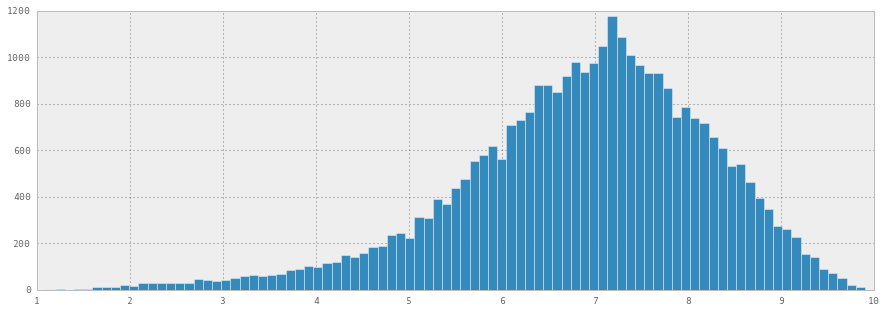

In [6]:
# print len(df['rating'].unique())
df['rating'].hist(bins=90)
print 'mean:', df['rating'].mean(), 'median', df['rating'].median(), 

In [7]:
# Only the movies 
dfm = df[df['episode'].isnull()]

### Top movies

In [8]:
dfm[['title', 'rating', 'year', 'votes']].sort_values('rating', ascending=False)[:25]

,title,rating,year,votes
28004,The Last of Us,9.8,2013,24082
31327,Wiedzmin 3: Dziki Gon,9.8,2015,3159
20520,Metal Gear Solid,9.7,1998,7748
31843,Zeruda no densetsu: Toki no okarina,9.7,1998,5257
22646,Planescape: Torment,9.7,1999,1419
10708,BoBoiBoy: The Movie,9.7,2016,1368
15549,Grand Theft Auto V,9.7,2013,28338
20524,Metal Gear Solid 3: Subsistence,9.6,2005,1473
23202,Radovan III,9.6,1983,1127
27152,The Elder Scrolls V: Skyrim,9.6,2011,16430


In [9]:
dfm[['title', 'rating', 'year', 'votes']
  ][df['votes'] < 10000
  ].sort_values('rating', ascending=False)[:25]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,title,rating,year,votes
31327,Wiedzmin 3: Dziki Gon,9.8,2015,3159
31843,Zeruda no densetsu: Toki no okarina,9.7,1998,5257
20520,Metal Gear Solid,9.7,1998,7748
22646,Planescape: Torment,9.7,1999,1419
10708,BoBoiBoy: The Movie,9.7,2016,1368
14282,Fallout 2: A Post-Nuclear Role-Playing Game,9.6,1998,2670
25359,Star Wars: Knights of the Old Republic,9.6,2003,5438
23202,Radovan III,9.6,1983,1127
14727,Forgotten Realms: Baldur's Gate II - Shadows o...,9.6,2000,1394
14263,Fainaru fantaj� VII,9.6,1997,6821


# Finding movies that divide people a lot 

In [10]:
def p_to_prop(p):
    if p == '.':
        r = 0.
    elif p == '*':
        r = 1.
    else:
        r=0.05+int(p)*0.1
    return r

In [11]:
p_dist_att = re.compile('[\d*.]{10}')

def dist_to_props(dist):
    
    if type(dist) is float:
        dist = int(dist)
    dist = str(dist)
    
    if len(dist) < 10:
        dist = '0'*(10-len(dist))+dist
    
    # testing if the dist ahere to the format:
    if p_dist_att.match(dist) and len(dist) == 10:
        props = np.array([p_to_prop(p) for p in dist])
        props /= np.sum(props)  # normalize
    else:
        props = None
        
    return props

# tests
print dist_to_props('4378234782') is not None
print dist_to_props('4378234782234') is None
print dist_to_props('234') is not None
print dist_to_props(4378234782.0) is not None
# This one should fail but it is OK for now 
print dist_to_props('234.*') is not None  


True
True
True
True
True


In [12]:
def props_to_avg(props):
    W_scores = [(i+1)*prop for i, prop in enumerate(props)] 
    return np.sum(W_scores)

def props_to_std(props):
#     Weighted standard deviation / 2nd moment: 
#     http://www.itl.nist.gov/div898/software/dataplot/refman2/ch2/weightsd.pdf
    std = np.sqrt(np.sum(props*(range(1, 11)-props_to_avg(props))**2))
    return std

def dist_to_avg(dist):
    props = dist_to_props(dist)
    if props is not None:
        r = props_to_avg(props)
    else:
        r = np.NaN
        print 'problem with ', dist
    return r

def dist_to_std(dist):
    props = dist_to_props(dist)
    if props is not None:
        r = props_to_std(props)
    else:
        r = np.NaN
        print 'problem with ', dist
    return r


print 'testing distribution stats:'
print df.loc[0]
print
print 'std:', dist_to_std(df['distribution'][0])
print 'dist avg', dist_to_avg(df['distribution'][0])
print 'real rating', df['rating'][0]
    

testing distribution stats:
index                          0
rating                       6.3
votes                       4415
title           $#*! My Dad Says
episode                      NaN
year                        2010
distribution          0000011101
Name: 0, dtype: object

std: 2.60874597375
dist avg 6.5
real rating 6.3


In [13]:
# adding new stats
df['dist_std'] = df['distribution'].apply(dist_to_std)
df['dist_avg'] = df['distribution'].apply(dist_to_avg)

In [14]:
dfm = df[df['episode'].isnull()]

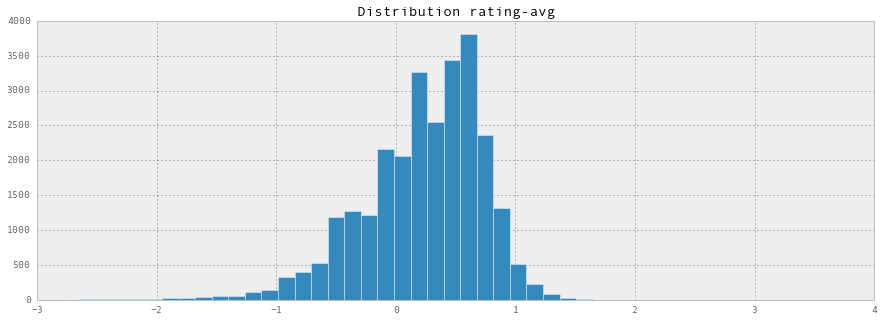

In [15]:
# How bad is the estimating of the rating

(dfm['rating']-dfm['dist_avg']).hist(bins=50)
pl.title('Distribution rating-avg')

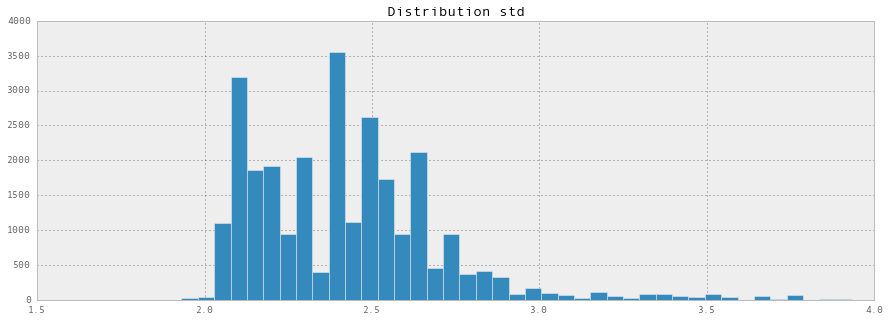

In [16]:
dfm['dist_std'].hist(bins=50)
pl.title('Distribution std')

### Real ratings are higher than the estimate!

In [17]:
dfm[['title', 'rating', 'year', 'votes', 'dist_std']
   ].sort_values('dist_std', ascending=False)[:10]

,title,rating,year,votes,dist_std
9666,Audacity,4.8,2015,3955,3.982583
21521,Night Train to Mundo Fine,2.7,1966,5821,3.954063
30209,Troppo belli,2.9,2005,4386,3.954063
20848,Monster a-Go Go,2.3,1965,6174,3.892984
29158,The Starfighters,2.3,1964,2977,3.892984
12109,Cool Cat Saves the Kids,4.0,2015,1770,3.892984
29888,Titanic - La leggenda continua,2.1,2000,7534,3.892984
10234,Ben & Arthur,2.2,2002,6898,3.892984
14370,Fat Slags,2.6,2004,3533,3.892984
29624,The Wrecking Crew,4.2,2000,1067,3.887078


[Audacity @ imdb](http://www.imdb.com/title/tt4172402/ratings?ref_=tt_ov_rt)
* 40.9% voted 1 
* 51.2% voted 10 
* 3965 IMDb users have given a weighted average vote of 4.8 / 10


### Popular movies that divide people

In [18]:
dfm[df['rating'] > 7.0][['title', 'rating', 'year', 'votes', 'dist_std']].sort_values('dist_std', ascending=False)[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,title,rating,year,votes,dist_std
8734,Adolf Hitler: The Greatest Story Never Told,7.7,2013,1840,3.703708
3480,Kurtlar Vadisi,7.1,2003,8212,3.417565
4624,Rebelde Way,7.2,2002,1510,3.377429
15502,Gopala Gopala,7.7,2015,2594,3.372427
20419,Meet the Mormons,7.1,2014,1662,3.372427
29520,The Weight of Chains,8.3,2010,3429,3.372427
30155,Treto poluvreme,8.0,2012,7634,3.364670
15681,Gunda,8.0,1998,7138,3.364670
21600,Nisshartho Bhalobasha: What is Love!,8.0,2013,7898,3.364670
30029,Tossing a Nigger in a Blanket,7.9,1898,1825,3.364670


[Adolf Hitler: The Greatest Story Never Told](http://www.imdb.com/title/tt3526810/ratings?ref_=tt_ov_rt)
* 1222	 65.5%	10
* 144	 7.7%	9
* 68	 3.6%	8
* 20	 1.1%	7
* 5	 0.3%	6
* 9	 0.5%	5
* 4	 0.2%	4
* 9	 0.5%	3
* 10	 0.5%	2
* 374	 20.1%	1


In [19]:
dfm[df['rating'] > 8.0][['title', 'rating', 'year', 'votes', 'dist_std']].sort_values('dist_std', ascending=False)[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,title,rating,year,votes,dist_std
29520,The Weight of Chains,8.3,2010,3429,3.372427
4429,Planet Earth,9.5,2006,94398,3.319523
19181,League of Legends,8.1,2009,1093,3.245616
7041,The Twilight Zone,9.0,1959,42123,3.193234
3564,Life,9.2,2009,21646,3.193234
3992,Monty Python's Flying Circus,8.9,1969,42600,3.193234
20232,Mario Kart Wii,8.2,2008,1245,3.113311
24701,Sicilian Vampire,9.0,2015,8051,3.031089
10072,Battle of Surabaya,8.5,2015,2301,2.961530
17856,Kabhi Haan Kabhi Naa,8.1,1994,11556,2.961530


[The Weight of Chains](http://www.imdb.com/title/tt1789083/ratings?ref_=tt_ov_rt)
* 2014     58.4%  10
* 403  11.7%  9
* 245  7.1%   8
* 118  3.4%   7
* 45   1.3%   6
* 35   1.0%   5
* 14   0.4%   4
* 25   0.7%   3
* 81   2.3%   2
* 468  13.6%  1
* Arithmetic mean = 8.1.  Median = 10* 

### least dividing movies:

In [20]:
dfm[['title', 'rating', 'year', 'votes', 'dist_std']].sort_values('dist_std', ascending=True)[:10]

,title,rating,year,votes,dist_std
9023,All the World in a Design School,8.4,2015,1053,1.540092
12299,Crusty Demons 18: Twenty Years of Fear,8.3,2015,2979,1.950231
27811,The Island of Dr. Moreau,5.9,1977,3965,1.957447
20175,Mannenharten,5.7,2013,1289,1.957447
10453,Billy Bathgate,5.9,1991,9457,1.957447
25867,S�ptimo,5.8,2013,3128,1.957447
26727,The Calling,5.8,2014,5536,1.957447
19760,Louis and the Nazis,7.8,2003,1126,1.957890
23648,Rob the Mob,6.3,2014,8348,1.967562
10629,Blood Work,6.4,2002,33648,1.967562


[All the world in a design school](http://www.imdb.com/title/tt2865822/ratings?ref_=tt_ov_rt)
* 116  9.7%   10
* 392  32.7%  9
* 565  47.2%  8
* 107  8.9%   7
* 15   1.3%   6
* 1    0.1%   5
* 0       4
* 1    0.1%   3
* 0       2
* 0       1 


In [21]:
dfm[df['votes'] > 10000][['title', 'rating', 'year', 'votes', 'dist_std']].sort_values('dist_std', ascending=True)[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,title,rating,year,votes,dist_std
17627,Joe Kidd,6.5,1972,12026,1.967562
10629,Blood Work,6.4,2002,33648,1.967562
15478,Good People,5.5,2014,10859,1.978618
28894,The Rookie,5.8,1990,19686,2.008762
26064,Te wu mi cheng,5.8,2001,12132,2.008762
9022,All the Right Moves,5.9,1983,12019,2.008762
26872,The Contract,5.7,2006,20059,2.008762
9506,Armored,5.7,2009,25823,2.008762
22380,Passenger 57,5.8,1992,35732,2.008762
14545,Firewall,5.8,2006,49230,2.008762


## Trends over years 

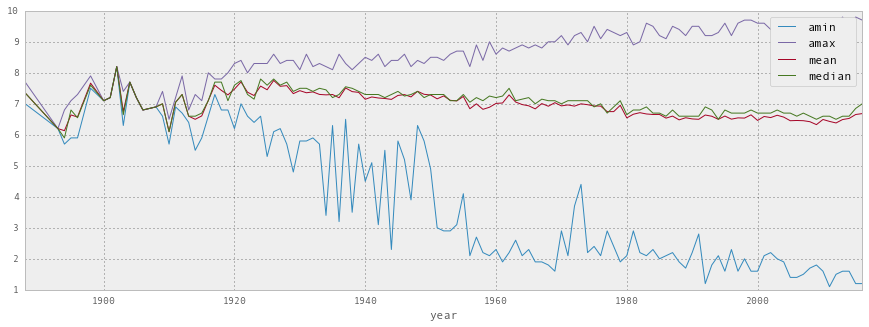

In [22]:
for func in [np.min, np.max, np.mean, np.median]:
    dfm.groupby('year')['rating'].apply(func).plot(label=func.func_name)
pl.legend()

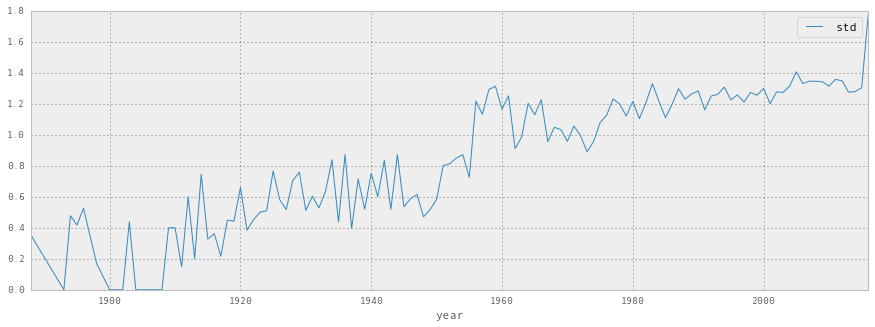

In [23]:
for func in [np.std]:
    dfm.groupby('year')['rating'].apply(func).plot(label=func.func_name)
pl.legend()

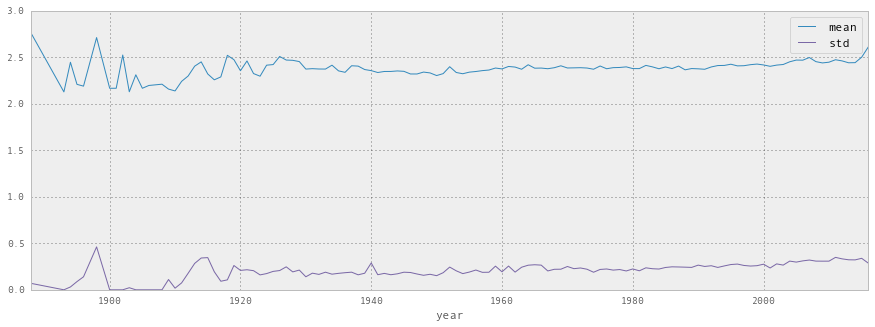

In [24]:
for func in [np.mean, np.std]:
    dfm.groupby('year')['dist_std'].apply(func).plot(label=func.func_name)
pl.legend()

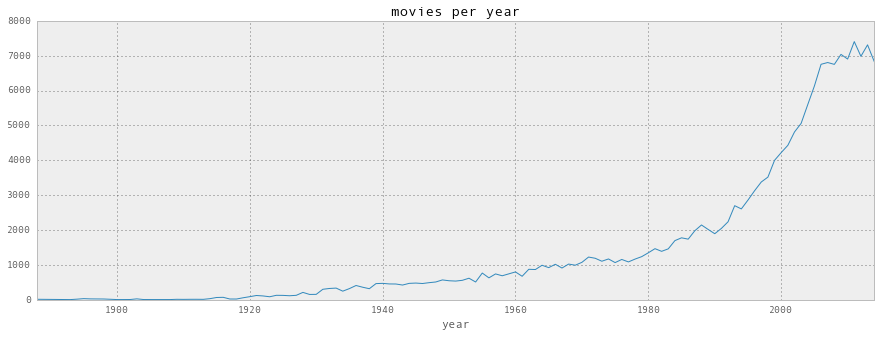

In [25]:
dfm[dfm['year'] < 2015].groupby('year')['rating'].apply(np.sum).plot()
pl.title('movies per year')